In [1]:
sys.path.insert(0, '../functions')
import tensorflow as tf                                                                                                                          
from energyflow.archs import PFN                                                                                                                 
from training_functions import *                                                                                                                 
from sklearn.preprocessing import StandardScaler                                                                                                 
import h5py as h5                                                                                                                                
import matplotlib.pyplot as plt                                                                                                       
import numpy as np                                                                                                                               
import os                                                                                                                                        
import shutil

In [2]:
from matplotlib import style
style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')
colors = ['#348ABD','#C70039','#FF5733','#FFC300','#65E88F','#40E0D0']

## Train, Val, Test Data

In [3]:
h5_filename = "2M_uncompressed.hdf5"

In [4]:
label = "notebook_test"  #Replace with your own variation!      
path = "./"+label
batch_size=1000

shutil.rmtree(path, ignore_errors=True)                                                                       
os.makedirs(path)                                                                                             

## Define the generators: Treating our samples as an infinite stream of data, reading one chunk at a time

In [5]:
recalc_scalar = True
N_Scalar_Batches = 100
do_norm = True #False for Debugging ONLY
train_generator = tf.data.Dataset.from_generator(
    training_generator(h5_filename,'train_hcal','train_mc',batch_size,do_norm,path,recalc_scalar),
    output_shapes=(tf.TensorShape([None,None,None]),[None]),
    output_types=(tf.float64, tf.float64))
 
val_generator = tf.data.Dataset.from_generator(
    training_generator(h5_filename,'val_hcal','val_mc',batch_size,do_norm,path,recalc_scalar),
    output_shapes=(tf.TensorShape([None,None,None]),[None]),
    output_types=(tf.float64, tf.float64))

test_generator = tf.data.Dataset.from_generator(                                                                                              
    test_generator(h5_filename,'test_hcal',batch_size,do_norm,path,recalc_scalar),                                                                                
    output_shapes=(tf.TensorShape([None,None,None])),                                                                                            
    output_types=(tf.float64))

Calculating Mean and Stdev using 100 batches for train_hcal
Input Means =  [ 2.39142433e-01 -4.62825251e+00 -2.36877704e+00  4.33162939e+03]
Input Stdevs =  [5.49291730e-01 1.14474854e+03 1.15580933e+03 2.92112701e+02]
Calculating Mean and Stdev using 100 batches for train_mc
Target Means =  [ 2.11000000e+02  2.10102760e+07  1.00000000e+00 -4.21196371e-02
 -2.57704500e-02  5.01064453e+01  1.39570221e-01  1.58216190e+01
  5.29652367e+01  1.75166626e+01]
Target Stdevs =  [0.00000000e+00 2.34568620e+07 0.00000000e+00 1.35731726e+01
 1.35280685e+01 2.57900734e+01 4.47034836e-08 1.08128853e+01
 2.71608105e+01 7.21956539e+00]
Calculating Mean and Stdev using 100 batches for val_hcal


2022-11-15 16:34:40.748979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/global/home/users/ftoralesacosta/user_pkg/usr/lib:/global/home/users/ftoralesacosta/user_pkg/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-11-15 16:34:40.749005: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-15 16:34:40.749380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

Input Means =  [ 2.39664078e-01 -6.23308229e+00 -5.09636045e-01  4.33240625e+03]
Input Stdevs =  [5.49368083e-01 1.13912231e+03 1.15630859e+03 2.92006378e+02]
Calculating Mean and Stdev using 100 batches for val_mc
Target Means =  [ 2.11000000e+02  2.10265500e+07  1.00000000e+00 -8.95005986e-02
 -4.28442433e-02  5.01147156e+01  1.39570221e-01  1.58227100e+01
  5.29707184e+01  1.75182571e+01]
Target Stdevs =  [0.00000000e+00 2.34973860e+07 0.00000000e+00 1.35150270e+01
 1.35650406e+01 2.57795887e+01 4.47034836e-08 1.07850800e+01
 2.71449966e+01 7.20649862e+00]
Calculating Mean and Stdev using 100 batches for test_hcal
Input Means =  [ 2.39135191e-01 -9.64025676e-01 -3.48632789e+00  4.33127051e+03]
Input Stdevs =  [5.49081087e-01 1.14077258e+03 1.15841260e+03 2.91774689e+02]


get_np_from_gen(h5_filename,n_batches,batch_size=1000,do_norm=True):## QA Immediatley Before Training: 
Plot the Cell Data for Training, Validation, and Test Datasets

In [6]:
input_array,target_array,val_input_data,val_target_data,test_array = \
get_np_from_gen(h5_filename,10,batch_size=1000,do_norm=True)

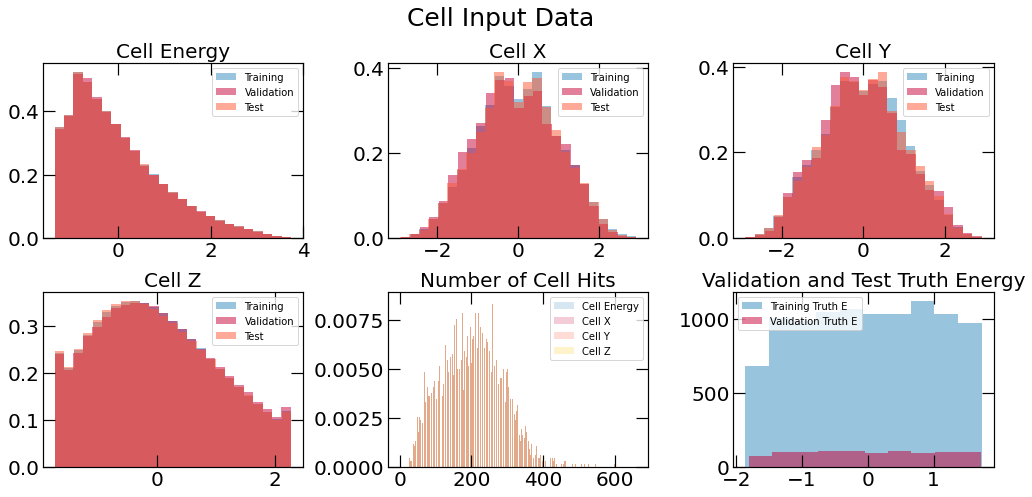

In [8]:
cell_vars = ["Cell Energy","Cell X","Cell Y","Cell Z"]

fig,axes=plt.subplots(2,3,figsize=(14,7))
axes = axes.ravel()
density = True
for i in range(input_array.shape[-1]):
    axes[i].hist(np.ravel(input_array[:,:,i][input_array[:,:,i]!=0]),alpha=0.5,label="Training",bins=25,density=density)
    axes[i].hist(np.ravel(val_input_data[:,:,i][val_input_data[:,:,i]!=0]),alpha=0.5,label="Validation",bins=25,density=density)
    axes[i].hist(np.ravel(test_array[:,:,i][test_array[:,:,i]!=0]),alpha=0.5,label="Test",bins=25,density=density)
    axes[i].legend(fontsize=10)
    axes[i].set_title("%s"%(cell_vars[i]),fontsize=20)

    #N Cell Hits
    axes[4].hist(np.ravel(np.count_nonzero(input_array[:,:,i],axis=-1)),
             bins=1000,alpha=0.2,
             density=True, label=cell_vars[i])
    
axes[4].legend(fontsize=10)
axes[4].set_title("Number of Cell Hits",fontsize=20)
    
axes[5].hist(target_array,alpha=0.5,label="Training Truth E",density=True)
axes[5].hist(val_target_data,alpha=0.5,label="Validation Truth E",density=True)
axes[5].legend(fontsize=10)
axes[5].set_title("Validation and Test Truth Energy",fontsize=20)
        
plt.suptitle("Cell Input Data",fontsize=25)
plt.tight_layout()
    
plt.savefig("%s/Normalized_Cell_Data.pdf"%(path))

## Hyper Parameters

In [9]:
h5_file = h5.File(h5_filename,'r')
do_normalization = True                                                                                       
input_dim = h5_file['train_hcal'].shape[-2] #should be 4: Cell E,X,Y,Z, the number of features per particle   
learning_rate = 1e-3                                                                                          
dropout_rate = 0.05                                                                                           
batch_size = 1_000                                                                                            
#N_Epochs = 50                                                                                                
N_Epochs = 1                                                                                                
patience = 10                                                                                                 
N_Latent = 128                                                                                                
shuffle_split = True #Turn FALSE for images!                                                                  
train_shuffle = True #Turn TRUE for images!                                                                   
Y_scalar = True                                                                                               
loss = 'mae' #'mae' #'swish'                                                                                  

## Define Model + CallBacks

In [10]:
Phi_sizes, F_sizes = (100, 100, N_Latent), (100, 100, 100)
output_act, output_dim = 'linear', 1 #Train to predict error

pfn = PFN(input_dim=input_dim,                                                                                
          Phi_sizes=Phi_sizes,                                                                                
          F_sizes=F_sizes,                                                                                    
          output_act=output_act,                                                                              
          output_dim=output_dim,                                                                              
          loss=loss,                                                                                          
          latent_dropout=dropout_rate,                                                                        
          F_dropouts=dropout_rate,                                                                            
          optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 4)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    500         ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation[0][0]']             
                                                                                              

### CallBacks

In [11]:
# Tensorflow CallBacks                                                                                        
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decay,verbose=0)                                   
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)                                          
history_logger=tf.keras.callbacks.CSVLogger(path+"/log.csv", separator=",", append=True)                      
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path, save_best_only=True)                     
callbacks=[lr_scheduler, early_stopping,history_logger,batch_history(),model_checkpoint] 

# FIT

In [ ]:
history = pfn.fit(                                                                                            
    train_generator,                                                                                          
    epochs=N_Epochs,                                                                                          
    batch_size=batch_size,                                                                                    
    callbacks=callbacks,                                                                                      
    validation_data=val_generator,                                                                            
    verbose=1                                                                                                 
)

   1000/Unknown - 1090s 1s/step - loss: 2.3817 - acc: 0.0000e+00

In [ ]:
#save batch loss                                                                                              
np.save("%s/batch_loss.npy"%(path),batch_history.batch_loss)                                                  
                                                                                                              
#save epoch loss                                                                                              
with open(path+'/history_file', 'wb') as hist_file:                                                           
    pickle.dump(history.history, hist_file)                                                                   
                                                                                                              
pfn.layers                                                                                                    
pfn.save("%s/energy_regression.h5"%(path))                                                                    
mypreds = pfn.predict(test_generator, batch_size=1000)                                                        
np.save("%s/predictions.npy"%(path),mypreds)                                                                  
#FIXME: un-norm the predictions 